In [24]:
import json

import numpy as np
from scipy.sparse.linalg import lsqr
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from ballbeam.paths import ROOT_PATH

In [25]:
def load_log_data(path):
    with path.open() as f:
        log_data = json.load(f)
    return pd.DataFrame(log_data)


data = {}
for path in (ROOT_PATH / "data" / "aligned").glob("*.json"):
    key = path.stem
    df = load_log_data(path)
    max_obs = df.observation.abs().max()
    # Drop examples where the observation blew up. Garbage.
    if max_obs > 0.15:
        print(f"Skipping {key} due to excessive max observation {max_obs:6.3f}")
        continue
    data[key] = df

In [26]:
def create_rolling_window(arr, k):
    T = len(arr)
    if not k < T:
        raise ValueError("k must be less than the length of the input array")

    result = np.lib.stride_tricks.sliding_window_view(arr, window_shape=k)
    return result[:-1]

def clipped_mean(x, lp, up):
    lb = np.percentile(x, lp, axis=0)
    ub = np.percentile(x, up, axis=0)
    return np.mean(np.clip(x, lb, ub), axis=0)

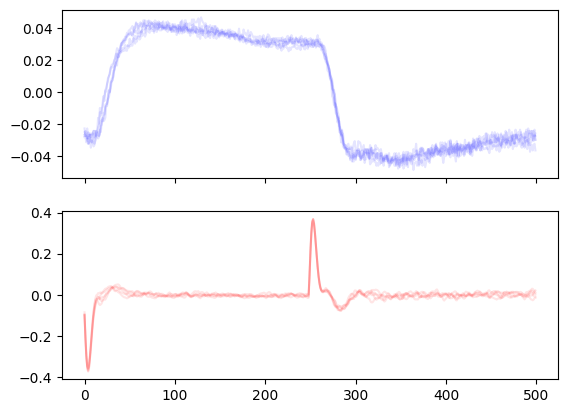

In [27]:
obs_df = pd.DataFrame({key: df.observation for key, df in data.items()})
act_df = pd.DataFrame({key: df.action for key, df in data.items()})

Y = obs_df.to_numpy().T
U = act_df.to_numpy().T

y = Y.flatten()
u = U.flatten()

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(Y.T, c="b", alpha=0.1)
axs[1].plot(U.T, c="r", alpha=0.1)
plt.show()

In [28]:
k = 60   # filter length

In [29]:
# # Pick sections around the setpoint changes
# a = int(1.1*k)   # backward duration
# b = int(1.1*k)   #  forward duration
# p = 250  # period length
# l = u.size
# num_periods = int(l / p)
# ys = []
# us = []

# for i in range(1, num_periods):
#     c = i * p
#     ys.append(y[c-a:c+b])
#     us.append(u[c-a:c+b])
# Y = np.array(ys)
# U = np.array(us)


# fig, axs = plt.subplots(nrows=2, sharex=True)
# axs[0].plot(Y.T, c="b", alpha=0.01)
# axs[1].plot(U.T, c="r", alpha=0.01)
# axs[1].axvline(k, c="k", linestyle="--", alpha=0.7)
# axs[1].axvline(a+b-k, c="k", linestyle="--", alpha=0.7)

# plt.show()

In [30]:
# Average batches of examples to reduce noise
batch_size = 1
num_batches = Y.shape[0] // batch_size
Ynew = np.zeros((num_batches, Y.shape[1]))
Unew = np.zeros((num_batches, U.shape[1]))
for i in range(num_batches):
    start = i * batch_size
    stop = start + batch_size
    Ynew[i] = clipped_mean(Y[start:stop], lp=25, up=75)
    Unew[i] = clipped_mean(U[start:stop], lp=25, up=75)

Y = Ynew
U = Unew

In [31]:
N = len(Y)
yrs = []
urs = []
yurs = []
yts = []
for i in range(N):
    y = Y[i]
    u = U[i]

    yr = create_rolling_window(y, k)
    ur = create_rolling_window(u, k)
    yur = np.hstack([yr, ur])
    yt = y[k:]
    
    yrs.append(yr)
    urs.append(ur)
    yurs.append(yur)
    yts.append(yt)

yrs = np.vstack(yrs)
urs = np.vstack(urs)
yurs = np.vstack(yurs)
yts = np.hstack(yts)

YUR = yurs
Yt = yts

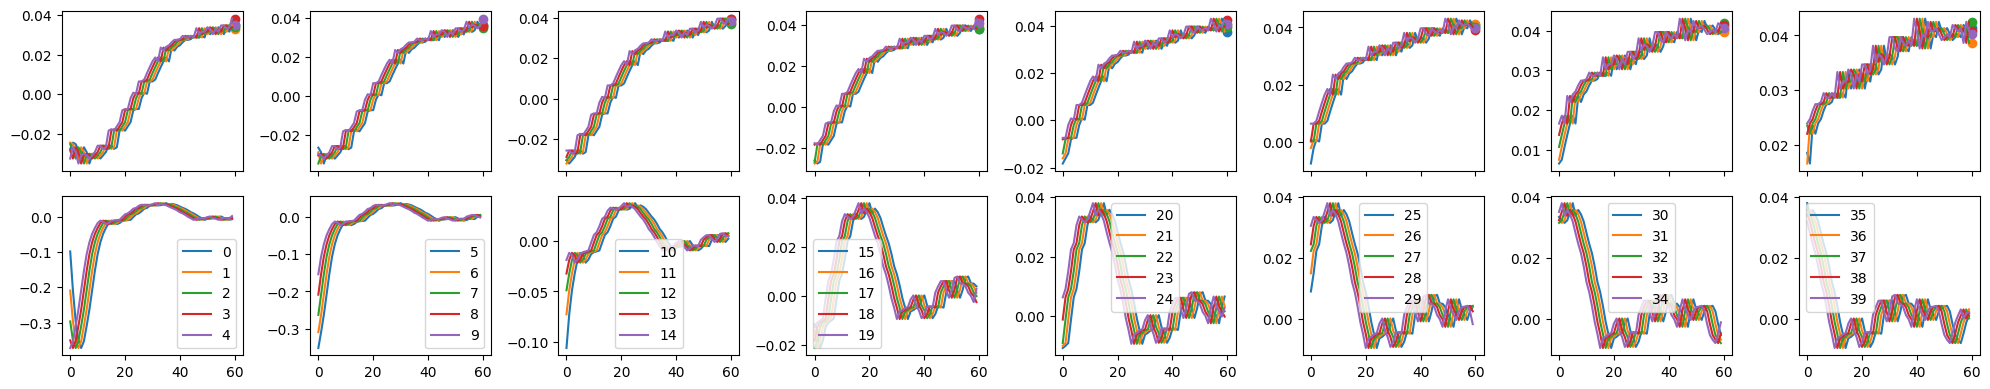

In [32]:
examples_per_batch = 5
num_batches = 8
fig, axs = plt.subplots(nrows=2, ncols=num_batches, sharex=True, figsize=(20, 4))
for i in range(num_batches):
    start = i * examples_per_batch
    stop = start + examples_per_batch
    for j, cj in zip(range(start, stop), range(examples_per_batch)):
        axs[0, i].plot(yrs[j], c=f"C{cj}", label=j)
        axs[0, i].scatter(k, yts[j], c=f"C{cj}", label=j)
        axs[1, i].plot(urs[j], c=f"C{cj}", label=j)
    axs[1, i].legend()
plt.tight_layout()
plt.show()

In [33]:
# Train multistep predictor model
# y_damp = 1e-9
# u_damp = 1e-9

y_damp = 1e-1 * np.linalg.eigh(yrs.T @ yrs).eigenvalues.min()
u_damp = 1e-2 * np.linalg.eigh(urs.T @ urs).eigenvalues.min()

# result = lsqr(YUR, Yt, damp=damp)
# theta = result[0]

# Set the regularizer

R = np.diag(np.hstack([
    y_damp * np.ones(k),
    u_damp * np.ones(k),
    ]))

# R = np.diag(np.hstack([
#     1e1 * np.ones(k),
#     np.linspace(1e2, 1e-3, k),
#     ]))

# R = damp * np.eye(2*k)

theta = np.linalg.solve(YUR.T @ YUR + R, YUR.T @ Yt)

In [34]:
y_coeffs = np.copy(np.flip(theta[0:k]))
u_coeffs = np.copy(np.flip(theta[k:]))
# y_coeffs /= np.sum(np.abs(y_coeffs))
# u_coeffs /= np.sum(np.abs(u_coeffs))
theta_df = pd.DataFrame({"y_coeffs": y_coeffs, "u_coeffs": u_coeffs})
px.bar(theta_df, barmode="group")

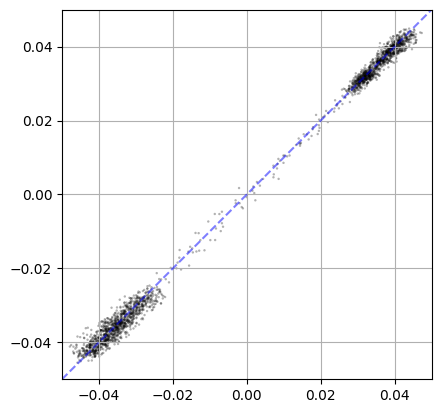

In [35]:
# One-step lookahead results

# Prediction
yt_hat = YUR @ theta

# Add visual jitter for quantized x-values
plt.scatter(Yt + 0.001 * np.random.rand(len(Yt)), yt_hat, alpha=0.3, s=3, c="k", edgecolors="none")
plt.plot([-0.05, 0.05], [-0.05, 0.05], linestyle="--", c="b", alpha=0.5)
plt.axis("square")
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.grid(True)
plt.show()

In [36]:
# # Open-loop control, closed-loop prediction, simulation of the ARX model
# i = 1
# yr = yrs[i]
# ur = urs[i]

# y_hist = []
# y = yr[0]
# for j in range(len(ur)):
#     u = ur[j]
#     yu = np.hstack([y, u])
#     y_new = yu @ theta
#     y = np.roll(y, shift=-1)
#     y[-1] = y_new
#     y_hist.append(np.copy(y))
# y_hist = np.array(y_hist)


# # Ground truth
# yt = yts[i]

# ydf = pd.DataFrame({"y": yt, "y_hat": y_hist[:, -1]})
# px.line(ydf)


In [37]:
U = act_df.to_numpy().T
Y = obs_df.to_numpy().T

# Concatenate data from all periodic examples
# u = U.flatten()
# y = Y.flatten()

# Average data from all periodic examples
y = clipped_mean(Y, lp=25, up=75)
u = clipped_mean(U, lp=25, up=75)

yr = create_rolling_window(y, k)
ur = create_rolling_window(u, k)
yur = np.hstack([yr, ur])

yt = y[k:]

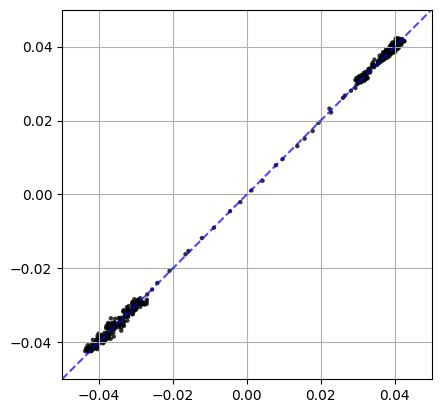

In [38]:
# One-step prediction, averaged data

# Prediction
yt_hat = yur @ theta

# Add visual jitter for quantized x-values
plt.scatter(yt + 0.0001 * np.random.rand(len(yt)), yt_hat, alpha=0.8, s=10, c="k", edgecolors="none")
plt.plot([-0.05, 0.05], [-0.05, 0.05], linestyle="--", c="b", alpha=0.7)
plt.axis("square")
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.grid(True)
plt.show()

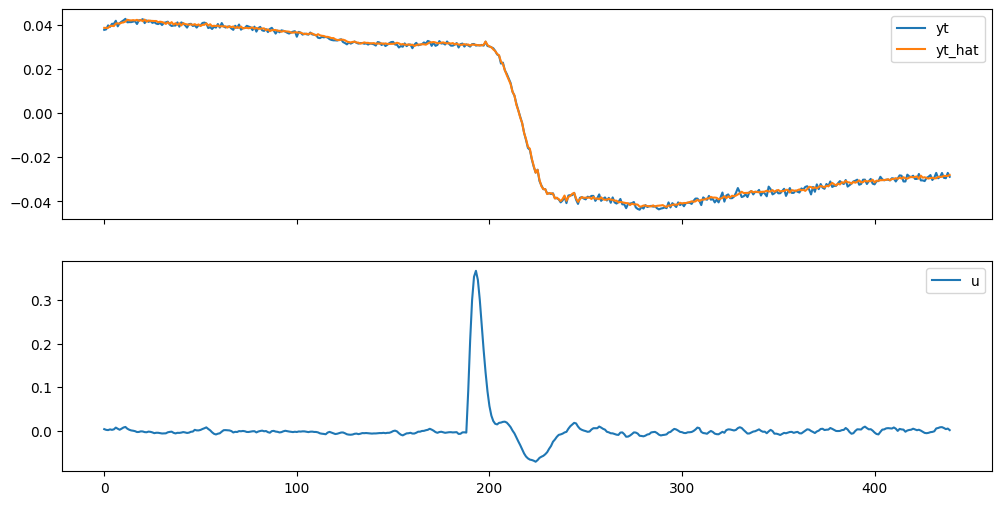

In [39]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axs[0].plot(yt, label="yt")
axs[0].plot(yt_hat, label="yt_hat")
axs[1].plot(u[k:], label="u")
axs[0].legend()
axs[1].legend()
plt.show()

In [40]:
T = len(ur)
omega = 0.01  # how much to cheat

In [41]:
# Closed-loop prediction, averaged data

y_hist = []
z = yr[0]
for j in range(T):
    u = ur[j]
    zu = np.hstack([z, u])
    z_new = zu @ theta

    # HACK
    z_new = (1 - omega) * z_new + omega * yt[j]

    z = np.roll(z, shift=-1)
    z[-1] = z_new
    y_hist.append(np.copy(z))
y_hist = np.array(y_hist)

In [42]:
# Closed-loop prediction, averaged data, zero action

y_hist_no_act = []
z = yr[0]
for j in range(T):
    u = 0 * ur[j]
    zu = np.hstack([z, u])
    z_new = zu @ theta

    # HACK
    z_new = (1 - omega) * z_new + omega * yt[j]

    z = np.roll(z, shift=-1)
    z[-1] = z_new
    y_hist_no_act.append(np.copy(z))
y_hist_no_act = np.array(y_hist_no_act)

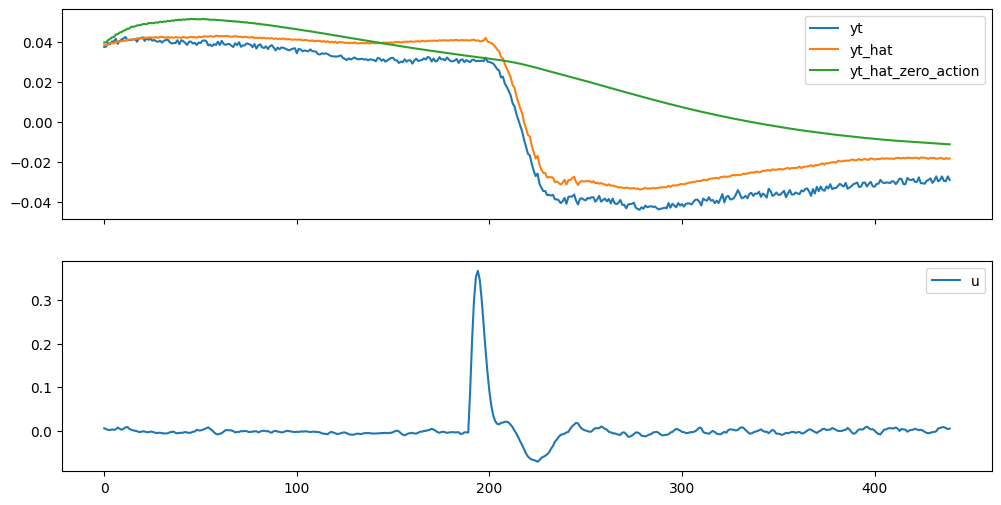

In [43]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axs[0].plot(yt, label="yt")
axs[0].plot(y_hist[:, -1], label="yt_hat")
axs[0].plot(y_hist_no_act[:, -1], label="yt_hat_zero_action")

axs[1].plot(ur[:, -1], label="u")
axs[0].legend()
axs[1].legend()
plt.show()

In [44]:
# TODO train a model on input-output history data

# ARX / ARMAX / GARCH
# https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.ARX.html
# statsmodels


# DMD with control
# SINDy with control

# Transformer NN
# RNN
# LSTM

In [45]:
# from statsmodels.tsa.api import SARIMAX

# mod = SARIMAX(y, exog=u, order=(k, 0, k))
# sarimax_res = mod.fit(method="bfgs")

In [46]:
# import numpy as np
# from pykoopman import Koopman
# from pykoopman.observables import Polynomial
# from pykoopman.operators import EDMDc


# # Step 2: Set up and fit the Koopman model with EDMDc
# observable = Polynomial(order=2)
# koopman_model = Koopman(observables=observable, operator=EDMDc())
# koopman_model.fit(Y, U)

# # Step 3: Predict future outputs
# y_pred = koopman_model.predict(Y, U)

# # Compare true and predicted outputs
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(y, label='True output')
# plt.plot(y_pred, '--', label='Predicted output')
# plt.legend()
# plt.xlabel('Time step')
# plt.ylabel('Output')

# plt.tight_layout()
# plt.show()

# # Step 4: Extract the learned system matrices A and B
# A_edmdc, B_edmdc = koopman_model.operator_.A, koopman_model.operator_.B
# print("Learned A matrix:\n", A_edmdc)
# print("Learned B matrix:\n", B_edmdc)
